In [2]:
import math 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import copy
import itertools

# Sklearn imports
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from multi_freq_ldpy.pure_frequency_oracles.GRR import GRR_Client
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
# LDP import
from GRR import GRR_Client
from GroupFairnessNotions import confusion_matrix_scorer, Statistical_parity, Metric_disparity, Equal_opportunity, Predictive_equality, Treatment_equality, Overall_accuracy, Predictive_rate_parity, CSD

In [4]:
# Evaluating nb_seed times due to randomness
nb_seed = 20

dataset = 'Synthetic6'
path_results = 'Results/'

# list of epsilon
#[8,2,1,0.8,0.5,0.40,0.27,0.2,0.1]
lst_eps = [16,8,2,1,0.85,0.5,0.40,0.27,0.23,0.1]

# Target attribute
target = 'Y' 

# Protected attribute 
protected_att = 'A'

test_size = 0.2

nb_samples = 1e5

lst_sensitive = [protected_att,'X']

In [5]:
def generate_synthetic_data(n):
#     X = np.random.binomial(1,p,n)
    X = np.random.randint(0,5,n)
    A = [np.random.binomial(1,0.55,1)[0] if x < 3 else np.random.binomial(1,0.75,1)[0] for x in X]
         #if x==1 else np.random.binomial(1,0.35,1)[0] if x==2 else np.random.binomial(1,0.45,1)[0] if x==3 else np.random.binomial(1,0.75,1)[0] for x in X]
    Y = [0.5*x + 0.75*a + np.random.normal(size=1) [0] for x,a in zip(X,A)]
    df = pd.DataFrame({'X': X, 'A': A, 'Y':Y})
    return df

In [6]:
df = generate_synthetic_data(100000)

In [7]:
df.A.value_counts()

1    62789
0    37211
Name: A, dtype: int64

In [8]:
df.X.value_counts()

4    20175
2    20104
1    20017
3    19862
0    19842
Name: X, dtype: int64

In [9]:
th=df.Y.quantile(.25)
#np.quantile(arr, .75)

In [10]:
#th=df.Y.quantile(.5)

In [11]:
#th=1

In [12]:
df.Y.describe()

count    100000.000000
mean          1.475462
std           1.313797
min          -3.803768
25%           0.567959
50%           1.479696
75%           2.387674
max           6.662169
Name: Y, dtype: float64

In [13]:
df['Y'] = df['Y'].apply(lambda x: 1 if x > th else 0)

#df['<= 53'] = df['mynumbers'].apply(lambda x: 'True' if x <= 53 else 'False')

In [14]:
df.Y.value_counts()

1    75000
0    25000
Name: Y, dtype: int64

## Data Distribution

In [15]:
print(df.Y.value_counts())
A0_Y0 = len(df[(df['A'] == 0) & (df['Y'] == 0)])
A0_Y1 = len(df[(df['A'] == 0) & (df['Y'] == 1)])
A1_Y0 = len(df[(df['A'] == 1) & (df['Y'] == 0)])
A1_Y1 = len(df[(df['A'] == 1) & (df['Y'] == 1)])
print(f'A0_Y0: {A0_Y0}\n A0_Y1: {A0_Y1}\n A1_Y0: {A1_Y0}\n A1_Y1: {A1_Y1}')

1    75000
0    25000
Name: Y, dtype: int64
A0_Y0: 15501
 A0_Y1: 21710
 A1_Y0: 9499
 A1_Y1: 53290


In [16]:
print(df.X.value_counts())
A0_X0_Y0 = len(df[(df['A'] == 0) & (df['X'] == 0) & (df['Y'] == 0)])
A0_X1_Y0 = len(df[(df['A'] == 0) & (df['X'] == 1) & (df['Y'] == 0)])
A0_X2_Y0 = len(df[(df['A'] == 0) & (df['X'] == 2) & (df['Y'] == 0)])
A0_X3_Y0 = len(df[(df['A'] == 0) & (df['X'] == 3) & (df['Y'] == 0)])
A0_X4_Y0 = len(df[(df['A'] == 0) & (df['X'] == 4) & (df['Y'] == 0)])

A0_X0_Y1 = len(df[(df['A'] == 0) & (df['X'] == 0) & (df['Y'] == 1)])
A0_X1_Y1 = len(df[(df['A'] == 0) & (df['X'] == 1) & (df['Y'] == 1)])
A0_X2_Y1 = len(df[(df['A'] == 0) & (df['X'] == 2) & (df['Y'] == 1)])
A0_X3_Y1 = len(df[(df['A'] == 0) & (df['X'] == 3) & (df['Y'] == 1)])
A0_X4_Y1 = len(df[(df['A'] == 0) & (df['X'] == 4) & (df['Y'] == 1)])

A1_X0_Y0 = len(df[(df['A'] == 1) & (df['X'] == 0) & (df['Y'] == 0)])
A1_X1_Y0 = len(df[(df['A'] == 1) & (df['X'] == 1) & (df['Y'] == 0)])
A1_X2_Y0 = len(df[(df['A'] == 1) & (df['X'] == 2) & (df['Y'] == 0)])
A1_X3_Y0 = len(df[(df['A'] == 1) & (df['X'] == 3) & (df['Y'] == 0)])
A1_X4_Y0 = len(df[(df['A'] == 1) & (df['X'] == 4) & (df['Y'] == 0)])

A1_X0_Y1 = len(df[(df['A'] == 1) & (df['X'] == 0) & (df['Y'] == 1)])
A1_X1_Y1 = len(df[(df['A'] == 1) & (df['X'] == 1) & (df['Y'] == 1)])
A1_X2_Y1 = len(df[(df['A'] == 1) & (df['X'] == 2) & (df['Y'] == 1)])
A1_X3_Y1 = len(df[(df['A'] == 1) & (df['X'] == 3) & (df['Y'] == 1)])
A1_X4_Y1 = len(df[(df['A'] == 1) & (df['X'] == 4) & (df['Y'] == 1)])




print(f'A0_X0_Y0: {A0_X0_Y0/100000}\n') 
print(f'A0_X1_Y0: {A0_X1_Y0/100000}\n') 
print(f'A0_X2_Y0: {A0_X2_Y0/100000}\n') 
print(f'A0_X3_Y0: {A0_X3_Y0/10000}\n')
print(f'A0_X4_Y0: {A0_X4_Y0/100000}\n')

print(f'A0_X0_Y1: {A0_X0_Y1/100000}\n') 
print(f'A0_X1_Y1: {A0_X1_Y1/100000}\n') 
print(f'A0_X2_Y1: {A0_X2_Y1/100000}\n') 
print(f'A0_X3_Y1: {A0_X3_Y1/100000}\n')
print(f'A0_X4_Y1: {A0_X4_Y1/100000}\n')

print(f'A1_X0_Y0: {A1_X0_Y0/100000}\n') 
print(f'A1_X1_Y0: {A1_X1_Y0/100000}\n') 
print(f'A1_X2_Y0: {A1_X2_Y0/100000}\n') 
print(f'A1_X3_Y0: {A1_X3_Y0/10000}\n')
print(f'A1_X4_Y0: {A1_X4_Y0/100000}\n')

print(f'A1_X0_Y1: {A1_X0_Y1/100000}\n') 
print(f'A1_X1_Y1: {A1_X1_Y1/100000}\n') 
print(f'A1_X2_Y1: {A1_X2_Y1/100000}\n') 
print(f'A1_X3_Y1: {A1_X3_Y1/100000}\n')
print(f'A1_X4_Y1: {A1_X4_Y1/100000}\n')



l = [A0_X0_Y0,A0_X1_Y0,A1_X0_Y0,A1_X1_Y0,A0_X0_Y1,A0_X1_Y1,A1_X0_Y1,A1_X1_Y1,A0_X2_Y0,A0_X3_Y0,A1_X2_Y0,A1_X3_Y0,A0_X2_Y1,A0_X3_Y1,A1_X2_Y1,A1_X3_Y1,A0_X4_Y0,A1_X4_Y0,A0_X4_Y1,A1_X4_Y1]
x = sum(l)/100000






4    20175
2    20104
1    20017
3    19862
0    19842
Name: X, dtype: int64
A0_X0_Y0: 0.06381

A0_X1_Y0: 0.0481

A0_X2_Y0: 0.0308

A0_X3_Y0: 0.0829

A0_X4_Y0: 0.00401

A0_X0_Y1: 0.02487

A0_X1_Y1: 0.04295

A0_X2_Y1: 0.06053

A0_X3_Y1: 0.04231

A0_X4_Y1: 0.04644

A1_X0_Y0: 0.04578

A1_X1_Y0: 0.02688

A1_X2_Y0: 0.01292

A1_X3_Y0: 0.0712

A1_X4_Y0: 0.00229

A1_X0_Y1: 0.06396

A1_X1_Y1: 0.08224

A1_X2_Y1: 0.09679

A1_X3_Y1: 0.1409

A1_X4_Y1: 0.14901



In [17]:
x

1.0

In [18]:
A0 = len(df[(df['A'] == 0)])/len(df)
A1 = len(df[(df['A'] == 1)])/len(df)
X1 = len(df[(df['X'] == 1)])/len(df)
X0 = len(df[(df['X'] == 0)])/len(df)

# Non-private Random Forest (using train/test splitting)

In [19]:
np_sp_min1, np_sp_maj1, np_sd = [], [], []
np_acc1 = []
np_oa_min1, np_oa_maj1, np_oad = [], [], []
ndp_csp_minX0, ndp_csp_majX0, np_csd_X0, ndp_csp_minX1, ndp_csp_majX1, np_csd_X1 = [], [] ,[] , [],[], []
ndp_csp_minX2, ndp_csp_majX2, np_csd_X2, ndp_csp_minX3, ndp_csp_majX3, np_csd_X3 = [], [] ,[] , [],[], []
ndp_csp_minX4, ndp_csp_majX4, np_csd_X4 = [], [] ,[] 
np_eo_min1, np_eo_maj1, np_eod = [], [], []
np_pe_min1, np_pe_maj1, np_ped = [], [], []


for seed in range(nb_seed):
    print(seed)
    np.random.seed(seed) # for reproducibility
    
    # Use original datasets
    X = copy.deepcopy(df.drop(target, axis=1))
    y = copy.deepcopy(df[target])

    # Train test splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, stratify=y, random_state=seed)
    
    # instantiate and train model
    model = RandomForestClassifier(n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    # retrieving minority, majority from the test set
    X_test_min, X_test_maj = X_test[X_test[protected_att] == 0], X_test[X_test[protected_att] == 1]

    # predicted outcomes for minority, majority
    y_pred_min, y_pred_maj = model.predict(X_test_min), model.predict(X_test_maj)

    indices_min, indices_maj = X_test_min.index, X_test_maj.index
    y_test_min, y_test_maj = y_test.get(key = indices_min), y_test.get(key = indices_maj)
    
    # Needed for the computation of Cond.Stat.Disp
            
    # retrieving four groups: A=0_X=0, A0_X=1, A1_X=0, A1_X=1 from the test set

    X_test_min_X0, X_test_min_X1, X_test_maj_X0, X_test_maj_X1,X_test_min_X2, X_test_min_X3, X_test_maj_X2, X_test_maj_X3,X_test_min_X4, X_test_maj_X4 = X_test[(X_test[protected_att] == 0) & (X_test['X'] == 0)], X_test[(X_test[protected_att] == 0) & (X_test['X'] == 1)],X_test[(X_test[protected_att] == 1) & (X_test['X'] == 0)], X_test[(X_test[protected_att] == 1) & (X_test['X'] == 1)],X_test[(X_test[protected_att] == 0) & (X_test['X'] == 2)], X_test[(X_test[protected_att] == 0) & (X_test['X'] == 3)],X_test[(X_test[protected_att] == 1) & (X_test['X'] == 2)], X_test[(X_test[protected_att] == 1) & (X_test['X'] == 3)],X_test[(X_test[protected_att] == 0) & (X_test['X'] == 4)], X_test[(X_test[protected_att] == 1) & (X_test['X'] == 4)]
    
    
    # confusion matrix for minority, majority
    conf_matrix_min, conf_matrix_maj = confusion_matrix_scorer(y_test_min,y_pred_min), confusion_matrix_scorer(y_test_maj,y_pred_maj)
    
    # predicted outcomes for the four groups
    y_pred_min_X0, y_pred_min_X1, y_pred_maj_X0, y_pred_maj_X1,y_pred_min_X2, y_pred_min_X3, y_pred_maj_X2, y_pred_maj_X3,y_pred_min_X4, y_pred_maj_X4= model.predict(X_test_min_X0), model.predict(X_test_min_X1), model.predict(X_test_maj_X0), model.predict(X_test_maj_X1), model.predict(X_test_min_X2), model.predict(X_test_min_X3), model.predict(X_test_maj_X2), model.predict(X_test_maj_X3),model.predict(X_test_min_X4), model.predict(X_test_maj_X4)

    
    # computing fairness metrics
    np_sp_min1.append(Statistical_parity(y_pred_min))
    np_sp_maj1.append(Statistical_parity(y_pred_maj))
    np_sd.append(Metric_disparity(Statistical_parity(y_pred_maj), Statistical_parity(y_pred_min)))
    np_eo_min1.append(Equal_opportunity(conf_matrix_min))
    np_eo_maj1.append(Equal_opportunity(conf_matrix_maj))
    np_eod.append(Metric_disparity(Equal_opportunity(conf_matrix_maj), Equal_opportunity(conf_matrix_min)))
    np_pe_min1.append(Predictive_equality(conf_matrix_min))
    np_pe_maj1.append(Predictive_equality(conf_matrix_maj))
    np_ped.append(Metric_disparity(Predictive_equality(conf_matrix_maj), Predictive_equality(conf_matrix_min)))
    
    ndp_csp_minX0.append(Statistical_parity(y_pred_min_X0))
    ndp_csp_majX0.append(Statistical_parity(y_pred_maj_X0))
    np_csd_X0.append(Metric_disparity(Statistical_parity(y_pred_maj_X0), Statistical_parity(y_pred_min_X0)))
    
    ndp_csp_minX1.append(Statistical_parity(y_pred_min_X1))
    ndp_csp_majX1.append(Statistical_parity(y_pred_maj_X1))  
    np_csd_X1.append(Metric_disparity(Statistical_parity(y_pred_maj_X1), Statistical_parity(y_pred_min_X1)))
    
    ndp_csp_minX2.append(Statistical_parity(y_pred_min_X2))
    ndp_csp_majX2.append(Statistical_parity(y_pred_maj_X2))
    np_csd_X2.append(Metric_disparity(Statistical_parity(y_pred_maj_X2), Statistical_parity(y_pred_min_X2)))
    
    ndp_csp_minX3.append(Statistical_parity(y_pred_min_X3))
    ndp_csp_majX3.append(Statistical_parity(y_pred_maj_X3))  
    np_csd_X3.append(Metric_disparity(Statistical_parity(y_pred_maj_X3), Statistical_parity(y_pred_min_X3)))
    
    ndp_csp_minX4.append(Statistical_parity(y_pred_min_X4))
    ndp_csp_majX4.append(Statistical_parity(y_pred_maj_X4))  
    np_csd_X4.append(Metric_disparity(Statistical_parity(y_pred_maj_X4), Statistical_parity(y_pred_min_X4)))
    
    
    
    
    
    np_oa_min1.append(Overall_accuracy(y_test_min, y_pred_min))
    np_oa_maj1.append(Overall_accuracy(y_test_maj, y_pred_maj))
    np_oad.append(Metric_disparity(Overall_accuracy(y_test_maj, y_pred_maj), Overall_accuracy(y_test_min, y_pred_min)))
    np_acc1.append(acc)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [20]:
print("\n=======================================No DP=======================================\n")

print('Non-Private fairness notions considering the protected attribute '+str(protected_att)+':')
print("The predicted acceptance rate (statistical parity) for A=0 is:", np.mean(np_sp_min1))
print("The predicted acceptance rate (statistical parity) for A=1 is:", np.mean(np_sp_maj1))
print("The true positive rate (Equal Opporunity) for A=0 is:", np.mean(np_eo_min1))
print("The true positive rate (Equal Opporunity) for A=1 is:", np.mean(np_eo_maj1))
print("The false positive rate (Predictive Equality) for A=0 is:", np.mean(np_pe_min1))
print("The false positive rate (Predictive Equality) for A=1 is:", np.mean(np_pe_maj1))
print("The conditional acceptance rate for A=0/X=0 is:", np.mean(ndp_csp_minX0))
print("The conditional acceptance rate for A=1/X=0 is:", np.mean(ndp_csp_majX0)) 
print("The conditional acceptance rate for A=0/X=1 is:", np.mean(ndp_csp_minX1))
print("The conditional acceptance rate for A=1/X=1 is:", np.mean(ndp_csp_majX1))
print("The conditional acceptance rate for A=0/X=2 is:", np.mean(ndp_csp_minX2))
print("The conditional acceptance rate for A=1/X=2 is:", np.mean(ndp_csp_majX2)) 
print("The conditional acceptance rate for A=0/X=3 is:", np.mean(ndp_csp_minX3))
print("The conditional acceptance rate for A=1/X=3 is:", np.mean(ndp_csp_majX3))
print("The conditional acceptance rate for A=0/X=4 is:", np.mean(ndp_csp_minX4))
print("The conditional acceptance rate for A=1/X=4 is:", np.mean(ndp_csp_majX4))
# print("The overall accuracy for A=0 is:", np.mean(np_oa_min1))
# print("The overall accuracy for A=1 is:", np.mean(np_oa_maj1))
# print("The overall accuracy is:", np.mean(np_acc1))


=======================================No DP=======================================

Non-Private fairness notions considering the protected attribute A:
The predicted acceptance rate (statistical parity) for A=0 is: 0.5159301184862233
The predicted acceptance rate (statistical parity) for A=1 is: 1.0
The true positive rate (Equal Opporunity) for A=0 is: 0.6864510716574438
The true positive rate (Equal Opporunity) for A=1 is: 1.0
The false positive rate (Predictive Equality) for A=0 is: 0.27624182514078843
The false positive rate (Predictive Equality) for A=1 is: 1.0
The conditional acceptance rate for A=0/X=0 is: 0.0
The conditional acceptance rate for A=1/X=0 is: 1.0
The conditional acceptance rate for A=0/X=1 is: 0.0
The conditional acceptance rate for A=1/X=1 is: 1.0
The conditional acceptance rate for A=0/X=2 is: 1.0
The conditional acceptance rate for A=1/X=2 is: 1.0
The conditional acceptance rate for A=0/X=3 is: 1.0
The conditional acceptance rate for A=1/X=3 is: 1.0
The condit

# Starting with Local Differential Privacy

In [21]:
starttime = time.time()
print("\n========= Setting 1: Local DP: only the sensitive feature is obfuscated =========\n")

df_cp = copy.deepcopy(df)

sldp_sp_min1, sldp_sp_maj1, sldp_sd, sd_std  = [], [], [], []
sldp_csp_minX0, sldp_csp_majX0, sldp_csd_X0, csd_X0_std, sldp_csp_minX1, sldp_csp_majX1, sldp_csd_X1, csd_X1_std = [], [] , [], [], [],[], [], []
sldp_csp_minX2, sldp_csp_majX2, sldp_csd_X2, csd_X2_std, sldp_csp_minX3, sldp_csp_majX3, sldp_csd_X3, csd_X3_std = [], [] , [], [], [],[], [], []
sldp_csp_minX4, sldp_csp_majX4, sldp_csd_X4, csd_X4_std= [], [] , [], []


sldp_oa_min1, sldp_oa_maj1, sldp_oad, oad_std = [], [], [], []
sldp_eo_min1, sldp_eo_maj1, sldp_eod, eod_std = [], [], [], []
sldp_pe_min1, sldp_pe_maj1, sldp_ped, ped_std = [], [], [], []
sldp_acc1 = []



for epsilon in lst_eps:
    print(epsilon)
    
    ldp_sp_min, ldp_sp_maj, ldp_sd = [], [], []
    ldp_csp_minX0, ldp_csp_majX0, ldp_csd_X0, ldp_csp_minX1, ldp_csp_majX1,ldp_csd_X1 = [], [],[], [], [], []
    ldp_csp_minX2, ldp_csp_majX2, ldp_csd_X2, ldp_csp_minX3, ldp_csp_majX3,ldp_csd_X3 = [], [],[], [], [], []
    ldp_csp_minX4, ldp_csp_majX4, ldp_csd_X4 = [], [],[]
    ldp_acc = []
    ldp_oa_min, ldp_oa_maj, ldp_oad  = [], [], []
    ldp_eo_min, ldp_eo_maj, ldp_eod  = [], [], []
    ldp_pe_min, ldp_pe_maj, ldp_ped = [], [], []
    
    for seed in range(nb_seed):
        #np.random.seed(seed)


        # Preparing X and y using pandas
        X = copy.deepcopy(df_cp.drop(target, axis=1))
        y = copy.deepcopy(df_cp[target])

        # Train test splitting
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, stratify=y, random_state=seed)

        # Attribute's domain size
        k = len(set(X[protected_att]))

        # Applying GRR to the protected attribute of the training set
        X_train[protected_att] = X_train[protected_att].apply(lambda x: GRR_Client(x, k, epsilon))
        
        # instantiate and train model
        model = RandomForestClassifier(n_jobs=-1)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test) # prediction of the actual samples
        
        acc = accuracy_score(y_test, y_pred)

        # retrieving minority, majority from the test set
        X_test_min, X_test_maj = X_test[X_test[protected_att] == 0], X_test[X_test[protected_att] == 1]

        # predicted outcomes for minority, majority
        y_pred_min, y_pred_maj = model.predict(X_test_min), model.predict(X_test_maj)

        indices_min, indices_maj = X_test_min.index, X_test_maj.index
        y_test_min, y_test_maj = y_test.get(key = indices_min), y_test.get(key = indices_maj)
        
        
        # Needed for the computation of Cond.Stat.Disp
            
        # retrieving four groups: A=0_X=0, A0_X=1, A1_X=0, A1_X=1 from the test set
            
        X_test_min_X0, X_test_min_X1, X_test_maj_X0, X_test_maj_X1,X_test_min_X2, X_test_min_X3, X_test_maj_X2, X_test_maj_X3,X_test_min_X4, X_test_maj_X4 = X_test[(X_test[protected_att] == 0) & (X_test['X'] == 0)], X_test[(X_test[protected_att] == 0) & (X_test['X'] == 1)],X_test[(X_test[protected_att] == 1) & (X_test['X'] == 0)], X_test[(X_test[protected_att] == 1) & (X_test['X'] == 1)],X_test[(X_test[protected_att] == 0) & (X_test['X'] == 2)], X_test[(X_test[protected_att] == 0) & (X_test['X'] == 3)],X_test[(X_test[protected_att] == 1) & (X_test['X'] == 2)], X_test[(X_test[protected_att] == 1) & (X_test['X'] == 3)],X_test[(X_test[protected_att] == 0) & (X_test['X'] == 4)], X_test[(X_test[protected_att] == 1) & (X_test['X'] == 4)]
        
        # confusion matrix for minority, majority
        conf_matrix_min, conf_matrix_maj = confusion_matrix_scorer(y_test_min,y_pred_min), confusion_matrix_scorer(y_test_maj,y_pred_maj)

        
        # predicted outcomes for the four groups
#         y_pred_min_X0, y_pred_min_X1, y_pred_maj_X0, y_pred_maj_X1 = model.predict(X_test_min_X0), model.predict(X_test_min_X1), model.predict(X_test_maj_X0), model.predict(X_test_maj_X1)  
#         
        # predicted outcomes for the four groups
        y_pred_min_X0, y_pred_min_X1, y_pred_maj_X0, y_pred_maj_X1,y_pred_min_X2, y_pred_min_X3, y_pred_maj_X2, y_pred_maj_X3,y_pred_min_X4, y_pred_maj_X4= model.predict(X_test_min_X0), model.predict(X_test_min_X1), model.predict(X_test_maj_X0), model.predict(X_test_maj_X1), model.predict(X_test_min_X2), model.predict(X_test_min_X3), model.predict(X_test_maj_X2), model.predict(X_test_maj_X3),model.predict(X_test_min_X4), model.predict(X_test_maj_X4)



#pred_A0_X0.append(y_pred_min_X0)
#         pred_A0_X1.append(y_pred_min_X1)
#         pred_A1_X0.append(y_pred_min_X0)
#         pred_A1_X1.append(y_pred_maj_X1)
        # computing fairness metrics with obfuscated A
        ldp_sp_min.append(Statistical_parity(y_pred_min))
        ldp_sp_maj.append(Statistical_parity(y_pred_maj))
        ldp_sd.append(Metric_disparity(Statistical_parity(y_pred_maj), Statistical_parity(y_pred_min)))
        
        ldp_eo_min.append(Equal_opportunity(conf_matrix_min))   
        ldp_eo_maj.append(Equal_opportunity(conf_matrix_maj))
        ldp_eod.append(Metric_disparity(Equal_opportunity(conf_matrix_maj), Equal_opportunity(conf_matrix_min)))
        
        ldp_pe_min.append(Predictive_equality(conf_matrix_min))
        ldp_pe_maj.append(Predictive_equality(conf_matrix_maj))
        ldp_ped.append(Metric_disparity(Predictive_equality(conf_matrix_maj), Predictive_equality(conf_matrix_min)))
        
        ldp_csp_minX0.append(Statistical_parity(y_pred_min_X0))
        ldp_csp_majX0.append(Statistical_parity(y_pred_maj_X0))
        ldp_csd_X0.append(Metric_disparity(Statistical_parity(y_pred_maj_X0), Statistical_parity(y_pred_min_X0)))
        
        ldp_csp_minX1.append(Statistical_parity(y_pred_min_X1))
        ldp_csp_majX1.append(Statistical_parity(y_pred_maj_X1))
        ldp_csd_X1.append(Metric_disparity(Statistical_parity(y_pred_maj_X1), Statistical_parity(y_pred_min_X1)))
        
        ldp_csp_minX2.append(Statistical_parity(y_pred_min_X2))
        ldp_csp_majX2.append(Statistical_parity(y_pred_maj_X2))
        ldp_csd_X2.append(Metric_disparity(Statistical_parity(y_pred_maj_X2), Statistical_parity(y_pred_min_X2)))
        
        ldp_csp_minX3.append(Statistical_parity(y_pred_min_X3))
        ldp_csp_majX3.append(Statistical_parity(y_pred_maj_X3))
        ldp_csd_X3.append(Metric_disparity(Statistical_parity(y_pred_maj_X3), Statistical_parity(y_pred_min_X3)))
       
        ldp_csp_minX4.append(Statistical_parity(y_pred_min_X4))
        ldp_csp_majX4.append(Statistical_parity(y_pred_maj_X4))
        ldp_csd_X4.append(Metric_disparity(Statistical_parity(y_pred_maj_X4), Statistical_parity(y_pred_min_X4)))
       
        
        
        ldp_oa_min.append(Overall_accuracy(y_test_min, y_pred_min))
        ldp_oad.append(Metric_disparity(Overall_accuracy(y_test_maj, y_pred_maj), Overall_accuracy(y_test_min, y_pred_min)))
        
        ldp_oa_maj.append(Overall_accuracy(y_test_maj, y_pred_maj))        
        ldp_acc.append(acc)

    #print(np.mean(ldp_sp_min))  
    sldp_sp_min1.append(np.mean(ldp_sp_min))
    sldp_sp_maj1.append(np.mean(ldp_sp_maj))
    sldp_sd.append(np.mean(ldp_sd))
    sd_std.append(np.std(sldp_sd))
    sldp_csp_minX0.append(np.mean(ldp_csp_minX0))
    sldp_csp_majX0.append(np.mean(ldp_csp_majX0))
    sldp_csd_X0.append(np.mean(ldp_csd_X0))
    csd_X0_std.append(np.std(sldp_csd_X0))
    sldp_csp_minX1.append(np.mean(ldp_csp_minX1))
    sldp_csp_majX1.append(np.mean(ldp_csp_majX1))
    sldp_csd_X1.append(np.mean(ldp_csd_X1))
    csd_X1_std.append(np.std(sldp_csd_X1))
    
    sldp_csp_minX2.append(np.mean(ldp_csp_minX2))
    sldp_csp_majX2.append(np.mean(ldp_csp_majX2))
    sldp_csd_X2.append(np.mean(ldp_csd_X2))
    csd_X2_std.append(np.std(sldp_csd_X2))
    sldp_csp_minX3.append(np.mean(ldp_csp_minX3))
    sldp_csp_majX3.append(np.mean(ldp_csp_majX3))
    sldp_csd_X3.append(np.mean(ldp_csd_X3))
    csd_X3_std.append(np.std(sldp_csd_X3))
    
    sldp_csp_minX4.append(np.mean(ldp_csp_minX4))
    sldp_csp_majX4.append(np.mean(ldp_csp_majX4))
    sldp_csd_X4.append(np.mean(ldp_csd_X4))
    csd_X4_std.append(np.std(sldp_csd_X4))
    
    
    
    
    sldp_oa_min1.append(np.mean(ldp_oa_min))
    sldp_oa_maj1.append(np.mean(ldp_oa_maj))
    sldp_oad.append(np.mean(ldp_oad))
    oad_std.append(np.std(sldp_oad))
    sldp_eo_min1.append(np.mean(ldp_eo_min))
    sldp_eo_maj1.append(np.mean(ldp_eo_maj))
    sldp_eod.append(np.mean(ldp_eod))
    eod_std.append(np.std(sldp_eod))
    sldp_pe_min1.append(np.mean(ldp_pe_min))
    sldp_pe_maj1.append(np.mean(ldp_pe_maj))
    sldp_ped.append(np.mean(ldp_ped))
    ped_std.append(np.std(sldp_ped))
    sldp_acc1.append(np.mean(ldp_acc))
    
#print(sldp_sp_min1)
    
print('That took {} seconds'.format(time.time() - starttime)) 



========= Setting 1: Local DP: only the sensitive feature is obfuscated =========

16
8
2
1
0.85
0.5
0.4
0.27
0.23
0.1
That took 525.6808769702911 seconds


In [22]:
print(f'SP for Majority, no LDP {np.mean(np_sp_maj1)}\t, sLDP {sldp_sp_maj1}\n SP for Minority, no LDP {np.mean(np_sp_min1)}\t, sLDP {sldp_sp_min1}')

print(f'CSP for Majority_X0, no LDP {np.mean(ndp_csp_majX0)}\t, sLDP {sldp_csp_majX0}\n CSP for Minority_X0, no LDP {np.mean(ndp_csp_minX0)}\t, sLDP {sldp_csp_minX0}')

print(f'CSP for Majority/X1, no LDP {np.mean(ndp_csp_majX1)}\t, sLDP {sldp_csp_majX1}\n CSP for Minority/X1, no LDP {np.mean(ndp_csp_minX1)}\t, sLDP {sldp_csp_minX1}')                                    


print(f'CSP for Majority_X2, no LDP {np.mean(ndp_csp_majX2)}\t, sLDP {sldp_csp_majX2}\n CSP for Minority_X2, no LDP {np.mean(ndp_csp_minX2)}\t, sLDP {sldp_csp_minX2}')

print(f'CSP for Majority/X3, no LDP {np.mean(ndp_csp_majX3)}\t, sLDP {sldp_csp_majX3}\n CSP for Minority/X3, no LDP {np.mean(ndp_csp_minX3)}\t, sLDP {sldp_csp_minX3}')                                    

print(f'CSP for Majority/X4, no LDP {np.mean(ndp_csp_majX4)}\t, sLDP {sldp_csp_majX4}\n CSP for Minority/X4, no LDP {np.mean(ndp_csp_minX4)}\t, sLDP {sldp_csp_minX4}')                                    
# print(f'Accuracy for Majority, no LDP {np.mean(np_oa_maj1)}\t, sLDP {sldp_oa_maj1}\n Accuracy for Minority, no LDP {np.mean(np_oa_min1)}\t, sLDP {sldp_oa_min1}')

print(f'EO for Majority, no LDP {np.mean(np_eo_maj1)}\t, sLDP {sldp_eo_maj1}\n EO for Minority, no LDP {np.mean(np_eo_min1)}\t, sLDP {sldp_eo_min1}')

# print(f'PE for Majority, no LDP {np.mean(np_pe_maj1)}\t, sLDP {sldp_pe_maj1}\n PE for Minority, no LDP {np.mean(np_pe_min1)}\t, sLDP {sldp_pe_min1}')



SP for Majority, no LDP 1.0	, sLDP [1.0, 1.0, 1.0, 1.0, 0.9737422362130255, 0.8250382507864519, 0.8250382507864519, 0.8250382507864519, 0.8250382507864519, 0.8250382507864519]
 SP for Minority, no LDP 0.5159301184862233	, sLDP [0.5159301184862233, 0.5159301184862233, 0.7622854802929216, 0.7622854802929216, 0.7622854802929216, 0.7622854802929216, 0.7622854802929216, 0.7622854802929216, 0.7622854802929216, 0.7622854802929216]
CSP for Majority_X0, no LDP 1.0	, sLDP [1.0, 1.0, 1.0, 1.0, 0.85, 0.0, 0.0, 0.0, 0.0, 0.0]
 CSP for Minority_X0, no LDP 0.0	, sLDP [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
CSP for Majority/X1, no LDP 1.0	, sLDP [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 CSP for Minority/X1, no LDP 0.0	, sLDP [0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
CSP for Majority_X2, no LDP 1.0	, sLDP [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 CSP for Minority_X2, no LDP 1.0	, sLDP [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
CSP for Majority/X3, no LDP 

## Visualization

In [23]:
def Make_subplots_2(lst_eps,dataset_name):    
    fig2, ax2 = plt.subplots(1, 2, figsize=(10, 5),sharex='col', sharey=True)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.yticks(fontsize=9)
    
    #ax2[0].axhline(y=np.mean(np_sp_maj1)-np.mean(np_sp_min1), color='black', label = 'noLDP')
    #ax2[0].errorbar(x,sldp_sd,sd_std,color='forestgreen', ecolor='forestgreen',label='SD',fmt='o',markersize=3)
    #ax2[0].errorbar(x,ldp_ind_spd2,std_values_indldp2['SPD'],ecolor='magenta',color='magenta',label='kRR-Ind',fmt='-o',markersize=3,alpha=0.6)            
    ax2[0].plot(sldp_sd,color='forestgreen', label='SD',marker='o', fillstyle='none')
    plt.annotate("Baseline", (lst_eps[0], np.mean(np_sp_maj1)-np.mean(np_sp_min1)))
    
    #ax2[1].axhline(y=np.mean(ndp_csp_majX0)-np.mean(ndp_csp_minX0), color='black', label = 'noLDP')
    #ax2[0].errorbar(x,sldp_csd_X0,csd_X0_std,color='red', ecolor='red',label='CSD_x0',fmt='D',markersize=3)
    ax2[0].plot(sldp_csd_X0,color='red',label='CSD_x0',marker='D', fillstyle='none')
    
    #ax2[0].axhline(y=np.mean(ndp_csp_majX1)-np.mean(ndp_csp_minX1), color='black', label = 'noLDP')
    #ax2[0].errorbar(x,sldp_csd_X1,csd_X1_std,color='orange', ecolor='orange',label='CSD_x1',fmt='-o',markersize=3)
    ax2[0].plot(sldp_csd_X1,color='orange', label='CSD_x1',marker='X', fillstyle='none')
    
    ax2[0].plot(sldp_csd_X2,color='purple',label='CSD_x2',marker='*', fillstyle='none')
    
    ax2[0].plot(sldp_csd_X3,color='pink',label='CSD_x3',marker='d', fillstyle='none')
    
    ax2[0].plot(sldp_csd_X4,color='black',label='CSD_x4',marker='v', fillstyle='none')
    
    #ax2[0].axhline(y=np.mean(np_eo_maj1)-np.mean(np_eo_min1), color='black', label = 'noLDP')
    #ax2[0].errorbar(x,sldp_eod,eod_std,color='blue', ecolor='blue',label='EOD',fmt='-o',markersize=3, alpha=0.4)
    ax2[0].plot(sldp_eod,color='blue', label='EOD',marker='v', alpha=0.4, fillstyle='none')
    
    #ax2[0].axhline(y=np.mean(np_sp_maj1)-np.mean(np_sp_min1), color='black', label = 'noLDP')
    #ax2[0].errorbar(x,sldp_sd,sd_std,color='forestgreen', ecolor='forestgreen',label='SD',fmt='o',markersize=3)
    #ax2[0].errorbar(x,ldp_ind_spd2,std_values_indldp2['SPD'],ecolor='magenta',color='magenta',label='kRR-Ind',fmt='-o',markersize=3,alpha=0.6)            
    ax2[1].plot(sldp_sd,color='forestgreen', label='SD',marker='o',markersize=3, fillstyle='none')
    
    
    #ax2[1].axhline(y=np.mean(ndp_csp_majX0)-np.mean(ndp_csp_minX0), color='black', label = 'noLDP')
    #ax2[0].errorbar(x,sldp_csd_X0,csd_X0_std,color='red', ecolor='red',label='CSD_x0',fmt='D',markersize=3)
    ax2[1].plot(sldp_csd_X0,color='red',label='CSD_x0',marker='D',markersize=3)
    
    #ax2[0].axhline(y=np.mean(ndp_csp_majX1)-np.mean(ndp_csp_minX1), color='black', label = 'noLDP')
    #ax2[0].errorbar(x,sldp_csd_X1,csd_X1_std,color='orange', ecolor='orange',label='CSD_x1',fmt='-o',markersize=3)
    ax2[1].plot(sldp_csd_X1,color='orange', label='CSD_x1',marker='X',markersize=3)
    
    #ax2[0].axhline(y=np.mean(np_eo_maj1)-np.mean(np_eo_min1), color='black', label = 'noLDP')
    #ax2[0].errorbar(x,sldp_eod,eod_std,color='blue', ecolor='blue',label='EOD',fmt='-o',markersize=3, alpha=0.4)
    ax2[1].plot(sldp_eod,color='blue', label='EOD',marker='v',markersize=3, alpha=0.4)
    ax2[1].plot(sldp_eod,color='yellow', label='PED',marker='v',markersize=3, alpha=0.4)
    
     
        
#     ax2[4].axhline(y=np.mean(np_pe_maj1)-np.mean(np_pe_min1), color='black', label = 'noLDP')
#     ax2[4].errorbar(x,sldp_ped,ped_std,color='forestgreen', ecolor='forestgreen',label='kRR-Comb',fmt='-o',markersize=3)
#     #ax2[2].errorbar(x,ldp_ind_ped2,std_values_indldp2['PED'],ecolor='magenta',color='magenta',label='kRR-Ind',fmt='-o',markersize=3,alpha=0.6)       
    
#     ax2[5].axhline(y=np.mean(np_oa_maj1)-np.mean(np_oa_min1), color='black', label = 'noLDP')
#     ax2[5].errorbar(x,sldp_oad,oad_std,color='forestgreen', ecolor='forestgreen',label='kRR-Comb',fmt='-o',markersize=3)
#     #ax2[3].errorbar(x,ldp_ind_oad2,std_values_indldp2['OAD'],ecolor='magenta',color='magenta',label='kRR-Ind',fmt='-o',markersize=3,alpha=0.6)       
    
#     ax2[4].axhline(y=PRP_maj_mean2-PRP_min_mean2, color='black', label = 'noLDP')
#     ax2[4].errorbar(x,allsldp_prpd2,std_values_comldp2['PRPD'],color='forestgreen', ecolor='forestgreen',label='kRR-Comb',fmt='-o',markersize=3)
#     ax2[4].errorbar(x,ldp_ind_prpd2,std_values_indldp2['PRPD'],ecolor='magenta',color='magenta',label='kRR-Ind',fmt='-o',markersize=3,alpha=0.6)       
 
    #ax2[0].set_title('Synthetic 2 \n No $X \perp A$',fontsize=12)
    ax2[1].set_title('Synthetic 2 \n ',fontsize=12)
#     ax2[2].set_title('CSD_x1',fontsize=12)
#     ax2[3].set_title('EOD',fontsize=12)
#     ax2[4].set_title('PED',fontsize=12)
#     ax2[5].set_title('OAD',fontsize=12)
#     ax2[4].set_title('PRD',fontsize=12)


    for j in range(2):
        ax2[j].set_xticks(range(len(lst_eps)))        
        ax2[j].set_xticklabels(lst_eps,fontsize=9)
        ax2[j].set_xlabel('$\epsilon$', fontsize=12)   
        ax2[j].grid(axis='y')
        ax2[j].legend(fontsize='8')
    # saving the plot as a pdf file
    fig2.savefig(path_results + dataset + '2.pdf',dpi=100,bbox_inches='tight')
    
    return fig2.show()

In [24]:
x = range(len(lst_eps))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


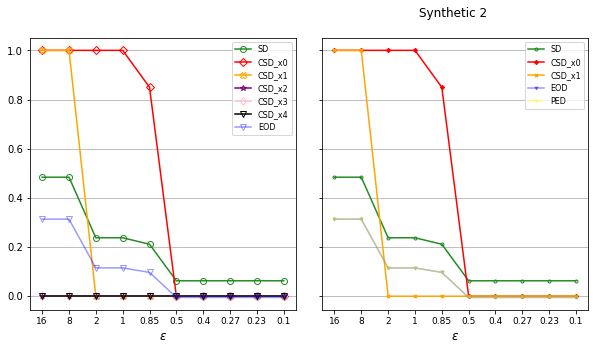

In [25]:
Make_subplots_2(lst_eps,'Synthetic2')

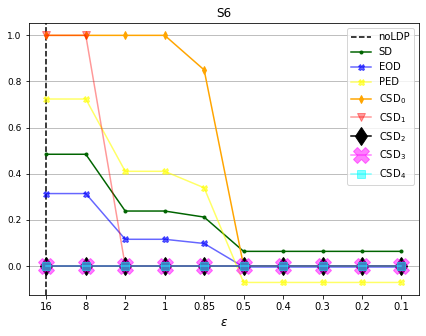

In [26]:
lst_eps = [16,8,2,1,0.85,0.5,0.4,0.3,0.2,0.1]
# specifying the plot size
plt.figure(figsize = (7, 5))
plt.axvline(x=range(len(lst_eps))[0], color='black', label = 'noLDP',linestyle='dashed')
plt.plot(sldp_sd,color='darkgreen',label='SD',marker='o',markersize=3)
plt.plot(sldp_eod,color='blue',label='EOD',marker='X',markersize=6, alpha=0.6)
plt.plot(sldp_ped,color='yellow',label='PED',marker='X',markersize=6, alpha=0.6)
plt.plot(sldp_csd_X0,color='orange',label='CSD$_{0}$',marker='d',markersize=5)
plt.plot(sldp_csd_X1,color='red', label='CSD$_{1}$',marker='v',markersize=8, alpha=0.4)
plt.plot(sldp_csd_X2,color='black',label='CSD$_{2}$',marker='d',markersize=13)
plt.plot(sldp_csd_X3,color='magenta', label='CSD$_{3}$',marker='X',markersize=16, alpha=0.5)
plt.plot(sldp_csd_X4,color='cyan', label='CSD$_{4}$',marker='s',markersize=8,alpha=0.5)

#plt.xticks(range(len(lst_eps)))  

#plt.xticklabels(range(len(lst_eps)))
plt.xticks(range(len(lst_eps)), lst_eps)
plt.yticks(fontsize=9)
plt.xlabel(lst_eps,fontsize=9)
plt.xlabel('$\epsilon$', fontsize=12)   
plt.grid(axis='y')
plt.title('S6',fontsize=12)
# place legend outside
plt.legend()

# saving the plot as a pdf file
#plt.savefig(path_results + dataset + '_S5.pdf',dpi=100,bbox_inches='tight')
# rendering plot
#plt.show()

plt.savefig(path_results + dataset + "_S62.pdf", format="pdf", bbox_inches="tight")
plt.show()
